In [193]:
from pathlib import Path
import fileinput
import pandas as pd

Setup the configs for this analysis

In [194]:
path_to_analysis_folder = Path("/home/leandro/git/pandora1_paper/cluster/analysis")
no_denovo_vcf = "../cluster/data/hps/nobackup/research/zi/projects/pandora_paper/analysis/100x/filter/compare_no_denovo/pandora_multisample_genotyped.vcf"
with_denovo_vcf = "../cluster/data/hps/nobackup/research/zi/projects/pandora_paper/analysis/100x/filter/compare_with_denovo/pandora_multisample_genotyped.vcf"
gene = "GC00000027_7"
covg = "100x"

Get a set of all the truth probes that map to the gene in "no_denovo"

In [195]:
def get_reports(path_to_analysis_folder: Path, covg: str, with_denovo: bool) -> list:
    denovo = "with" if with_denovo else "no"
    report_dir = path_to_analysis_folder / "recall/reports/"
    return list(report_dir.rglob(f"*/{covg}/pandora_nanopore_filter_{denovo}_denovo/*.tsv"))
    

In [196]:
reports = get_reports(path_to_analysis_folder, covg, with_denovo=False)

In [197]:
no_denovo_probes_map_to_gene = set()
with fileinput.input(reports) as fh:
    for line in fh:
        if gene in line:
            line_split = line.split("\t")
            truth_probe_header = line_split[1]
            no_denovo_probes_map_to_gene.add(truth_probe_header)
            

Lets take a look at what variant probes these truth probes do/dont map to for "with_denovo"


In [198]:
with_denovo_reports = get_reports(path_to_analysis_folder, covg, with_denovo=True)

In [199]:
df = pd.concat([pd.read_csv(p, sep="\t") for p in with_denovo_reports])

In [200]:
probes_of_interest = df.loc[df['query_probe_header'].isin(no_denovo_probes_map_to_gene)]
len(probes_of_interest)

712

In [201]:
from collections import Counter

print("Classification of truth probes in denovo (these truth probes map to the gene in no_denovo)")

Counter(probes_of_interest["classification"])



Classification of truth probes in denovo (these truth probes map to the gene in no_denovo)


Counter({'primary_correct': 349, 'unmapped': 353, 'primary_incorrect': 10})

We have a good amount of truth probes that maps to the gene in "no_denovo" and are unmapped in denovo (given that the delta=522, this should be the main issue)


In [202]:
with_denovo_probes_map_to_gene = set()
with fileinput.input(with_denovo_reports) as fh:
    for line in fh:
        if gene in line:
            truth_probe_header = line.split("\t")[1]
            with_denovo_probes_map_to_gene.add(truth_probe_header)
len(with_denovo_probes_map_to_gene)

325

TODO: plugin edit distance computation automatically here?

Edit distance for the 5 worst denovo genes right now (computed externally):

Gene: GC00000191_6, ED = 141, Prop ED = 0.037183544303797465

Gene: GC00000558_1, ED = 80, Prop ED = 0.032089851584436425

Gene: GC00003150, ED = 47, Prop ED = 0.031522468142186455

Gene: GC00000027_7, ED = 82, Prop ED = 0.019303201506591337

Gene: GC00003295_10, ED = 1657, Prop ED = 0.3118765292678336

In [203]:
import allel



In [204]:
vcf_fields = ["calldata/GT", "samples", "variants/CHROM", "variants/POS", ]

In [205]:
no_denovo_callset = allel.read_vcf(no_denovo_vcf, fields=vcf_fields, region=gene)
sorted(no_denovo_callset.keys())

['calldata/GT', 'samples', 'variants/CHROM', 'variants/POS']

In [206]:
with_denovo_callset = allel.read_vcf(with_denovo_vcf, fields=vcf_fields, region=gene)

In [207]:
no_denovo_gt = allel.GenotypeArray(no_denovo_callset['calldata/GT'])
with_denovo_gt = allel.GenotypeArray(with_denovo_callset['calldata/GT'])

In [208]:
no_denovo_haploid_calls = []
for a in no_denovo_gt:
    no_denovo_haploid_calls.extend([x[0] for x in a])

print(Counter(no_denovo_haploid_calls))

Counter({0: 357, -1: 188, 1: 118, 2: 7, 3: 3, 4: 2, 5: 1})


In [209]:
with_denovo_haploid_calls = []
for a in with_denovo_gt:
    with_denovo_haploid_calls.extend([x[0] for x in a])

print(Counter(with_denovo_haploid_calls))

Counter({0: 227, -1: 111, 1: 44, 2: 3, 4: 3})


In [210]:
import seaborn as sns
import matplotlib.pyplot as plt


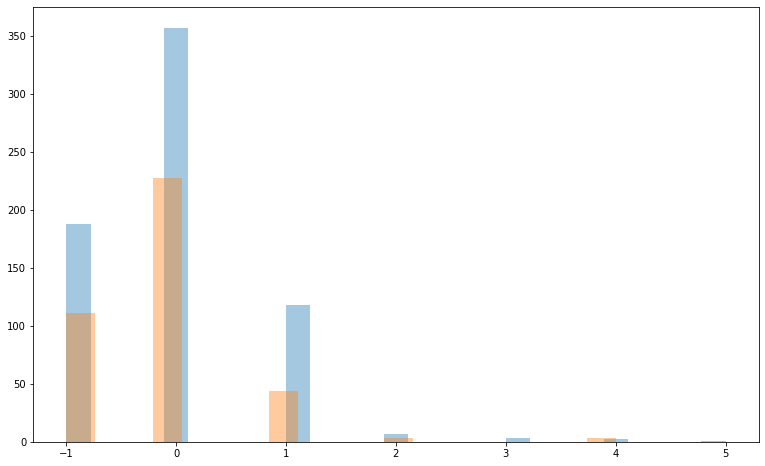

In [211]:
fig, ax = plt.subplots(figsize=(13,8))
sns.distplot(no_denovo_haploid_calls, ax=ax, label="no_denovo", kde=False)
sns.distplot(with_denovo_haploid_calls, ax=ax, label="with_denovo", kde=False)